In [13]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import poisson

from Generator.MatchingScore import MatchingScore
from Generator.parameters import *
%reload_ext autoreload
%autoreload 2

# Distributions

In [14]:
n_lang_dist = file_path["lang_level_dist"] # distribution of languages
n_language = [i+1 for i,_  in enumerate(n_lang_dist)] # Number of languages

n_certificate_dist = file_path["certificates_dist"] # distribution of certificate
n_certificates = [i for i,_  in enumerate(n_certificate_dist)] # Number of certificates

df_language_level = pd.read_csv(file_path["language_level"]) # dataframe with language levels
language_level_dist =  df_language_level["P"].tolist()
name_lang_levels = df_language_level["Level"]

poisson_dist = [poisson(lam=2) for _ in range(60000)]
poisson_x = [i for i in range(max(poisson_dist))]

df_education_level = pd.read_csv(file_path["education"]) # dataframe with language levels
education_level_dist =  df_education_level["P2"].tolist()
name_edu_levels = df_education_level["Education"]

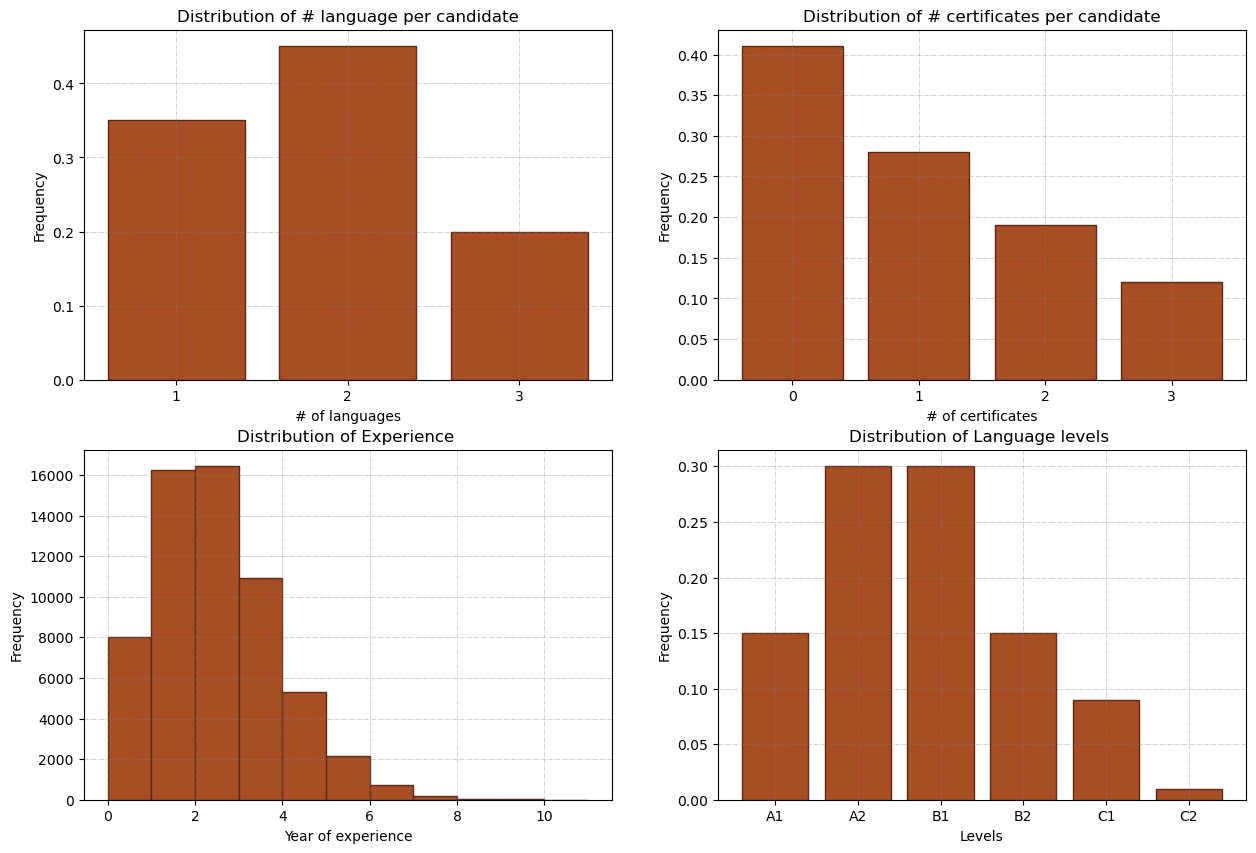

In [15]:
default_par = dict(
    color="#a74e25",
    edgecolor="#5b2a14"
)

f, axs = plt.subplots(ncols=2,nrows=2,figsize=(15,10))

axs[0,0].bar(range(len(n_lang_dist)), n_lang_dist, **default_par)
axs[0,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0,0].set_xticks(range(len(n_lang_dist)), n_language)
axs[0,0].set_title('Distribution of # language per candidate')
axs[0,0].set_xlabel('# of languages')
axs[0,0].set_ylabel('Frequency')

axs[0,1].bar(range(len(n_certificate_dist)), n_certificate_dist, **default_par)
axs[0,1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0,1].set_xticks(range(len(n_certificate_dist)), n_certificates)
axs[0,1].set_title('Distribution of # certificates per candidate')
axs[0,1].set_xlabel('# of certificates')
axs[0,1].set_ylabel('Frequency')

axs[1,0].hist(poisson_dist, poisson_x, **default_par)
axs[1,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,0].set_title('Distribution of Experience ')
axs[1,0].set_xlabel('Year of experience')
axs[1,0].set_ylabel('Frequency')

axs[1,1].bar(range(len(language_level_dist)), language_level_dist, **default_par)
axs[1,1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,1].set_xticks(range(len(language_level_dist)), name_lang_levels)
axs[1,1].set_title('Distribution of Language levels ')
axs[1,1].set_xlabel('Levels')
axs[1,1].set_ylabel('Frequency')

plt.show()


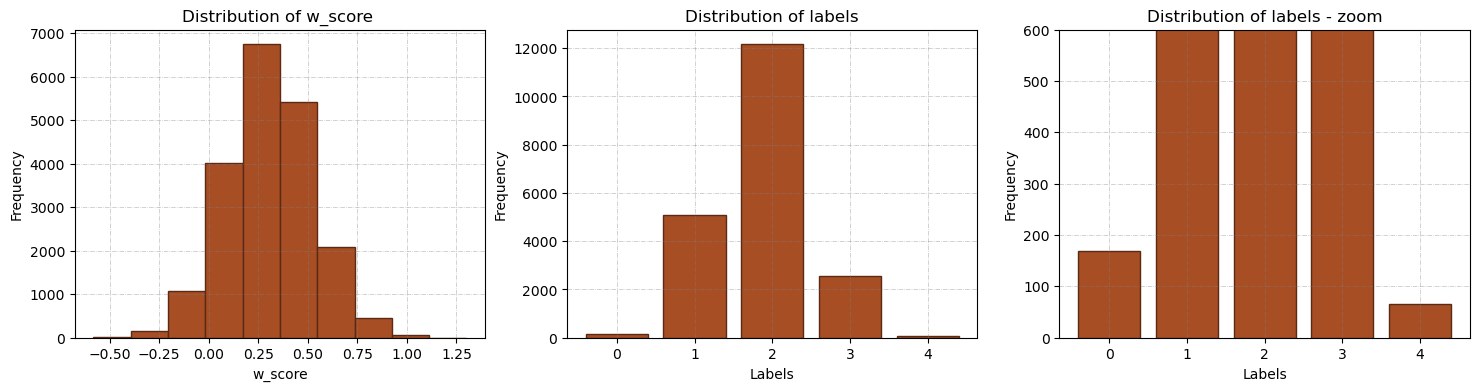

In [16]:
score_dt = pd.read_csv("../outputs/scores.csv")
labels = score_dt["labels"].tolist()
w_score = score_dt["w_score"].tolist()

distri_labels = [labels.count(i) for i in range(max(labels)+1)]
name_label = [*range(max(labels)+1)]

_, axs = plt.subplots(ncols=3,figsize=(18,4))

axs[0].hist(w_score, **default_par)
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0].set_title('Distribution of w_score ')
axs[0].set_xlabel('w_score')
axs[0].set_ylabel('Frequency')

axs[1].bar(name_label,distri_labels, **default_par)
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1].set_title('Distribution of labels')
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')

axs[2].bar(name_label,distri_labels, **default_par)
axs[2].set_ylim(0, 600)
axs[2].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[2].set_title('Distribution of labels - zoom')
axs[2].set_xlabel('Labels')
axs[2].set_ylabel('Frequency')


plt.show()

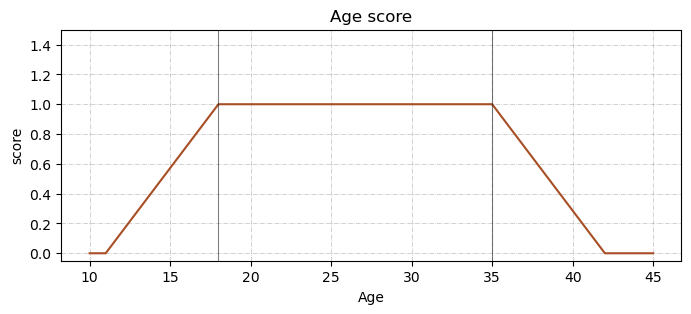

In [17]:
min_age, max_age = 18, 35
ages = [*range(10,45+1)]
age_score = [MatchingScore.ageScore(i,min_age,max_age) for i in ages]

_, axs = plt.subplots(figsize=(8,3))

axs.plot(ages,age_score, color=default_par["color"])
axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black")
axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Age score")
axs.set_xlabel('Age')
axs.set_ylabel('score')
axs.set_ylim(-0.05,1.5)
plt.show()

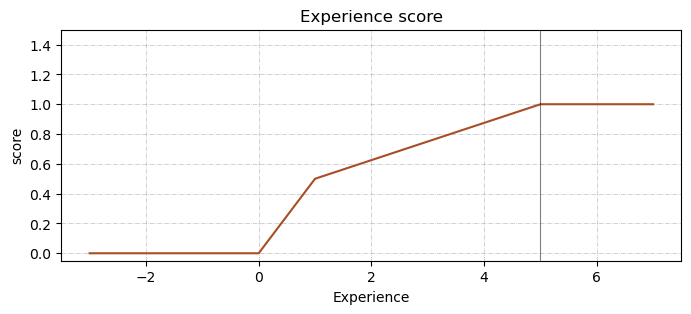

In [18]:
offer_exp = 5
experience = [*range(-3,8)]
exp_score = [MatchingScore.experienceScore(offer_exp, i) for i in experience]

_, axs = plt.subplots(figsize=(8,3))

axs.plot(experience, exp_score, color=default_par["color"])
axs.axvline(offer_exp, alpha=0.5,linewidth=0.8, color="black")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Experience score")
axs.set_xlabel('Experience')
axs.set_ylabel('score')
axs.set_ylim(-0.05,1.5)
plt.show()

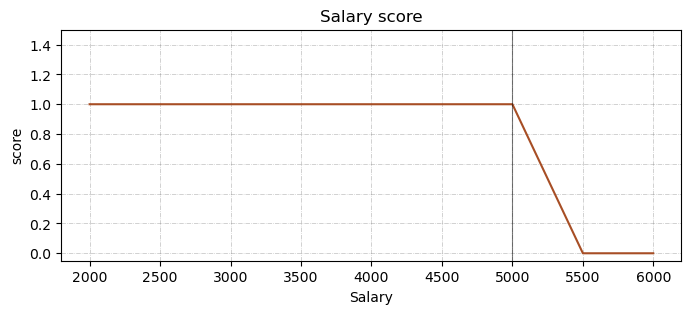

In [19]:
offer_exp = 5000
experience = [*range(2000,6000)]
exp_score = [MatchingScore.salaryScore(offer_exp, i) for i in experience]

_, axs = plt.subplots(figsize=(8,3))

axs.plot(experience, exp_score, color=default_par["color"])
axs.axvline(offer_exp, alpha=0.5,linewidth=0.8, color="black")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Salary score")
axs.set_xlabel('Salary')
axs.set_ylabel('score')
axs.set_ylim(-0.05,1.5)
plt.show()

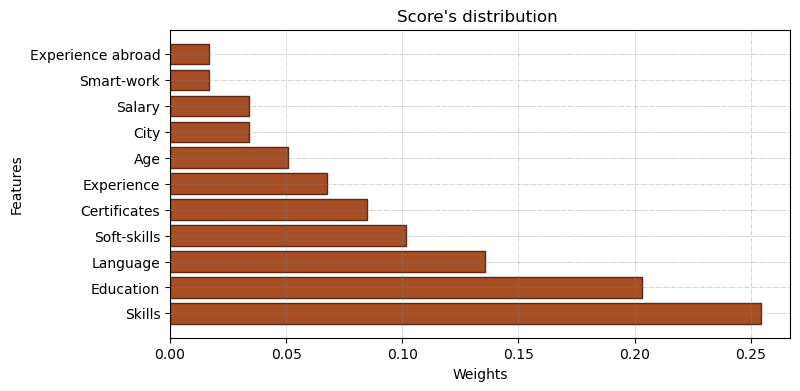

In [20]:
n_weights = MatchingScore.normalize_weights(matching_par["weight"])

sort_ = np.argsort(-n_weights)

features = np.array(["Education","City","Skills","Soft-skills","Age","Language","Certificates","Experience", "Salary","Smart-work","Experience abroad"])

_, axs = plt.subplots(figsize=(8,4))
axs.barh(range(len(n_weights)), n_weights[sort_], **default_par)
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_yticks(range(len(n_weights)), features[sort_])
axs.set_title('Score\'s distribution ')
axs.set_xlabel('Weights')
axs.set_ylabel('Features')
plt.show()